In [1]:
# read in libraries
import sys, os
import netCDF4
import scipy.io, numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.patches as mpatches

## 1. Read in data and basic calculations

In [73]:
directory = '/Users/evenhou/Downloads/armdata'

kappa_LH = 0.01
kappa_MH = 0.65

chi50 = np.array([]) 
chi100 = np.array([])
chi150 = np.array([])
chi200 = np.array([])
chi250 = np.array([])

for subdir, dirs, files in os.walk(directory):
    for file in files:
        filename = subdir + os.sep + file
        if ('sgpaoshtdmaE13.b1.20210613' in filename) and ('.nc' in filename):
# =============== FOR EACH FILE ===============
# get dimensions of time and bins
            ds = netCDF4.Dataset(filename)
            s1 = str(ds.dimensions['time'])
            s2 = str(ds.dimensions['bin'])
            # print(s)
            x = -3
            if (s1[x-1:x+1] != '='):
                dim_time = int(s1[x:])
            else:
                dim_time = int(s1[x-1:])
            if (s2[x-1:x+1] != '='):
                dim_bin = int(s2[x:])
            else:
                dim_bin = int(s2[x-1:])
            # print(dim_time, dim_bin)
            
# CHANGE HERE: define arrays
            time = np.zeros(dim_time)
            dry_dia = np.zeros(dim_time)
            kappa = np.zeros((dim_time, dim_bin))
            k_bound = np.zeros((dim_time, dim_bin,2))
            conc = np.zeros((dim_time, dim_bin))
            
# CHANGE HERE: read data into arrays
            ncf = scipy.io.netcdf_file(filename, mmap=False)
            date = int(filename[-18:-10]) # read i.e. 20210427
           
            time[:] = ncf.variables["time"].data/3600 # hr
            dry_dia[:] = ncf.variables["dry_diameter_setting"].data # nm
            for i_time in range(dim_time):
                kappa[i_time, :] = ncf.variables['kappa'][i_time, :]
                k_bound[i_time, :, :] = ncf.variables['kappa_bounds'][i_time, :, :]
                conc[i_time,:] = ncf.variables['aerosol_concentration'][i_time, :] # dN, unit: 1/cm^3

# calculations
            dK = np.zeros((dim_time,dim_bin))
            for i_time in range(dim_time):
                dK[i_time, :] = k_bound[i_time, :, 1] -  k_bound[i_time, :, 0]
            conc_norm0 = np.zeros((dim_time,dim_bin)) # dN/dK
            for i_time in range(dim_time):
                conc_norm0[i_time, :] = conc[i_time, :]/dK[i_time, :]

## 2. Interpolate on original data

In [74]:
# interpolate the raw data on 30 linearly spaced kappa bins
xnew = np.linspace(0, 1.3, 30) # K0
dNdK = np.zeros((dim_time, 30)) # dNdK
df_k = pd.DataFrame(columns=['dia', 'K0', 'dNdK'])

for i_time in range(dim_time):
    x = kappa[i_time, :] # one scan:kappa
    y = conc_norm0[i_time, :] # one scan: dNdK
    f = interpolate.interp1d(x,y,kind = 'nearest', fill_value= "extrapolate")
    ynew = f(xnew)
    dNdK[i_time,:] = ynew
dia = np.repeat(dry_dia, 30) # for one scan
t = np.repeat(time,30)
x_flat = np.tile(xnew, dim_time) # for different bin
y_flat = dNdK.ravel()

temp_df = pd.DataFrame({'time': t,'dia': dia,'K0': x_flat,'dNdK': y_flat})
df_k = pd.concat([df_k, temp_df], ignore_index=True)
print(df_k)

        dia        K0         dNdK       time
0     250.0  0.000000   454.932332   0.087222
1     250.0  0.044828   507.254582   0.087222
2     250.0  0.089655   705.266208   0.087222
3     250.0  0.134483  1868.896086   0.087222
4     250.0  0.179310   937.975221   0.087222
...     ...       ...          ...        ...
6835  100.0  1.120690     0.000000  23.983889
6836  100.0  1.165517     0.000000  23.983889
6837  100.0  1.210345     0.000000  23.983889
6838  100.0  1.255172     0.000000  23.983889
6839  100.0  1.300000     0.000000  23.983889

[6840 rows x 4 columns]


/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_87449/212204853.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_k = pd.concat([df_k, temp_df], ignore_index=True)


In [75]:
# df_k[0:60]

## 3. Cut off invalid kappa & corresponding concentration

In [76]:
# Update 'dNdK' where 'K0' is less than kappa_LH or greater than kappa_MH
df_k.loc[(df_k['K0'] < kappa_LH) | (df_k['K0'] > kappa_MH), 'dNdK'] = 0

In [77]:
# df_k[0:60]

## 4. Calculate N_tot

In [78]:
N_tot = np.array([])
for i in range(0,int(len(df_k)/30)):
    N_tot_i = (df_k.iloc[i*30:i*30+29].sum()).dNdK
    N_tot = np.append(N_tot,N_tot_i)


In [79]:
N_tot

array([  15762.5457416 ,   63915.80957215,  110567.39007663,
         59186.95392188,   56375.22057467,   23023.60542302,
         66336.66185626,  127375.31423558,   57164.03543247,
         40563.42592046,   13912.77495096,  127453.47124828,
        115890.87514086,   78922.40358033,   24659.05928771,
         20682.50217627,  183068.39903346,  106369.07457284,
         76240.55785869,   29415.79809455,   26839.70773208,
        128267.82397514,  116869.0028345 ,   79369.24244257,
         28801.0162634 ,   27704.39562246,  120407.11689338,
        131710.14149115,   82180.49016765,   33604.23867421,
         24453.85535669,  103015.44155054,  164178.22224645,
         65434.48322551,   46987.06996808,   31826.1579196 ,
         91296.80600689,  173857.23326372,   48837.89481443,
         53463.76651542,   19941.55986812,   84189.36361431,
        169567.53084446,   60067.86396338,   45903.63423354,
         24309.73751779,   79212.17186364,  156795.40108208,
         78536.56136587,

In [80]:
has_zero = np.any(N_tot == 0)
print(has_zero)

False


In [81]:
# check 
# sum_dNdK = df_k['dNdK'].iloc[:30].sum()

In [82]:
df_k['N_tot'] = np.repeat(N_tot,30)
# df_k[0:60]

## 5. Calculate conc_norm

In [83]:
df_k['conc_norm'] = df_k['dNdK']/df_k['N_tot']

In [84]:
df_k

,dia,K0,dNdK,time,N_tot,conc_norm
0,250.0,0.000000,0.000000,0.087222,15762.545742,0.000000
1,250.0,0.044828,507.254582,0.087222,15762.545742,0.032181
2,250.0,0.089655,705.266208,0.087222,15762.545742,0.044743
3,250.0,0.134483,1868.896086,0.087222,15762.545742,0.118566
4,250.0,0.179310,937.975221,0.087222,15762.545742,0.059507
...,...,...,...,...,...,...
6835,100.0,1.120690,0.000000,23.983889,942209.805468,0.000000
6836,100.0,1.165517,0.000000,23.983889,942209.805468,0.000000
6837,100.0,1.210345,0.000000,23.983889,942209.805468,0.000000
6838,100.0,1.255172,0.000000,23.983889,942209.805468,0.000000


In [85]:
df_k['p_MH_i'] = (df_k.K0-kappa_LH)/(kappa_MH-kappa_LH)
df_k['p_LH_i'] = 1 - df_k['p_MH_i']

In [86]:
dK = xnew[1]-xnew[0]

In [87]:
df_k['H_i'] = - df_k.p_LH_i * np.log(df_k.p_LH_i) - df_k.p_MH_i*np.log(df_k.p_MH_i)
df_k['H_alpha_i'] = df_k.H_i * df_k.conc_norm * dK
df_k['p_mh_i'] = df_k.p_MH_i * df_k.conc_norm * dK
df_k['p_lh_i'] = df_k.p_LH_i * df_k.conc_norm * dK

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [88]:
H_alpha = np.array([])
p_MH = np.array([])
p_LH = np.array([])
for i in range(0,int(len(df_k)/30)):
    h_alpha = (df_k.iloc[i*30:i*30+29].sum()).H_alpha_i
    p_mh = (df_k.iloc[i*30:i*30+29].sum()).p_mh_i
    p_lh = (df_k.iloc[i*30:i*30+29].sum()).p_lh_i
    H_alpha = np.append(H_alpha,h_alpha)
    p_MH = np.append(p_MH,p_mh)
    p_LH = np.append(p_LH,p_lh)

In [89]:
D_alpha = np.exp(H_alpha)
H_gamma = -p_LH*np.log(p_LH)-p_MH*np.log(p_MH)
D_gamma = np.exp(H_gamma)
chi = (D_alpha-1)/(D_gamma-1)

In [90]:
# np.isnan(chi)

In [91]:
d = {'dry_dia': dry_dia, 'time':time, 'date':date, 'N_tot':N_tot}
df = pd.DataFrame(data = d)

In [92]:
df

,dry_dia,time,date,N_tot
0,250.0,0.087222,20210613,15762.545742
1,50.0,0.192500,20210613,63915.809572
2,100.0,0.297500,20210613,110567.390077
3,150.0,0.402778,20210613,59186.953922
4,200.0,0.508056,20210613,56375.220575
...,...,...,...,...
223,150.0,23.562778,20210613,345452.507740
224,200.0,23.668056,20210613,196903.816366
225,250.0,23.773333,20210613,94397.041058
226,50.0,23.878611,20210613,423408.500892


In [93]:
df['p_MH'] = p_MH.tolist()
df['p_LH'] = p_LH.tolist()
df['D_alpha'] = D_alpha.tolist()
df['D_gamma'] = D_gamma.tolist()
df['chi'] = chi.tolist()

In [94]:
df

,dry_dia,time,date,N_tot,p_MH,p_LH,D_alpha,D_gamma,chi
0,250.0,0.087222,20210613,15762.545742,0.018649,0.026178,1.026961,1.184859,0.145849
1,50.0,0.192500,20210613,63915.809572,0.008184,0.036643,1.019563,1.174088,0.112372
2,100.0,0.297500,20210613,110567.390077,0.013535,0.031292,1.025170,1.181333,0.138805
3,150.0,0.402778,20210613,59186.953922,0.014245,0.030582,1.025440,1.182005,0.139778
4,200.0,0.508056,20210613,56375.220575,0.016310,0.028518,1.025954,1.183617,0.141351
...,...,...,...,...,...,...,...,...,...
223,150.0,23.562778,20210613,345452.507740,0.014817,0.030011,1.026400,1.182501,0.144656
224,200.0,23.668056,20210613,196903.816366,0.015866,0.028962,1.026869,1.183312,0.146576
225,250.0,23.773333,20210613,94397.041058,0.016315,0.028513,1.026184,1.183620,0.142598
226,50.0,23.878611,20210613,423408.500892,0.010407,0.034421,1.022086,1.177599,0.124360


In [95]:
df50 = df[df["dry_dia"] == 50]
df100 = df[df["dry_dia"] == 100]
df150 = df[df["dry_dia"] == 150]
df200 = df[df["dry_dia"] == 200]
df250 = df[df["dry_dia"] == 250]

In [96]:
chi50 = np.array([]) 
chi100 = np.array([])
chi150 = np.array([])
chi200 = np.array([])
chi250 = np.array([])

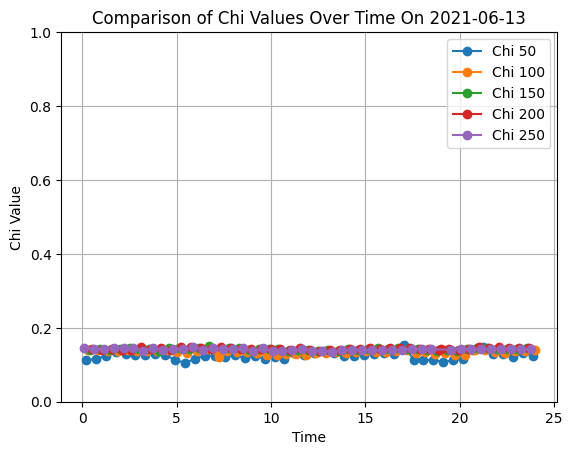

In [97]:
time50_i = df50["time"].to_numpy()
chi50_i = df50["chi"].to_numpy()
chi50 = np.append(chi50,chi50_i)

chi100_i = df100["chi"].to_numpy()
chi100 = np.append(chi100,chi100_i)

chi150_i = df150["chi"].to_numpy()
chi150 = np.append(chi150,chi150_i)

chi200_i = df200["chi"].to_numpy()
chi200 = np.append(chi200,chi200_i)

chi250_i = df250["chi"].to_numpy()
chi250 = np.append(chi250,chi250_i)

plt.plot(df50.time, chi50, label='Chi 50', marker='o')
plt.plot(df100.time, chi100, label='Chi 100', marker='o')
plt.plot(df150.time, chi150, label='Chi 150', marker='o')
plt.plot(df200.time, chi200, label='Chi 200', marker='o')
plt.plot(df250.time, chi250, label='Chi 250', marker='o')
date_str = f"{date:8}"  # Convert to string for formatting
formatted_date = f"{date_str[0:4]}-{date_str[4:6]}-{date_str[6:8]}"  # YYYY-MM-DD
plt.title(f'Comparison of Chi Values Over Time On {formatted_date}')
plt.xlabel('Time')
plt.xlabel('Time')
plt.ylabel('Chi Value')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()